In [83]:
from bs4 import BeautifulSoup, SoupStrainer
import bs4
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(["h1", "h2", "h3", "p"])  # Extraction des éléments pertinents
    ),
)
docs = loader.load()

if docs:
    text = docs[0].page_content  # Extraire le texte du premier document
    print(text[:1000])  # Afficher les 1000 premiers caractères
else:
    print("Erreur : Aucun document extrait !")

print(f"Nombre de documents importés : {len(docs)}")


      LLM Powered Autonomous Agents
    Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.Agent System Overview#In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:Component One: Planning#A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.Task Decomposition#Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tas

In [84]:
print(docs[0].page_content) 


      LLM Powered Autonomous Agents
    Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.Agent System Overview#In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:Component One: Planning#A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.Task Decomposition#Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tas

In [85]:
# Splitting 
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200, add_start_index=True
)
all_splits = text_splitter.split_documents(docs)

print(f"Nombre de chunks créés: {len(all_splits)}")
print(all_splits[1].page_content)
print(all_splits[2].page_content)

Nombre de chunks créés: 31
Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.Agent System Overview#In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:Component One: Planning#A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.Task Decomposition#Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed li

In [86]:
# Vector store
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

# Initialize model Embeddings
embeddings = HuggingFaceEmbeddings(
model_name="sentence-transformers/all-MiniLM-l6-v2",
model_kwargs={'device':'cpu'},
encode_kwargs={'normalize_embeddings': False}
)

# Database embedded
db = FAISS.from_documents(all_splits, embeddings)
print("FAISS vector store created successfully.")
print(f"Nombre de documents dans FAISS: {len(db.docstore._dict)}")

FAISS vector store created successfully.
Nombre de documents dans FAISS: 31


In [87]:
# Document ID’s (vector store)
document_ids = list(db.docstore._dict.keys())
print(document_ids[:5]) 

['f390ae54-66b5-44bd-8748-a34778ba8cb5', 'f590c309-e213-4571-9ed9-5f20e81a1b7e', '8eeb6453-a4d4-45d7-a206-85741df94770', 'ac716936-b514-4f30-9d3a-dd5a29bde2ca', '097077e0-a1e7-4f4f-b744-269c3a30c0b4']


In [88]:
# LangGraph Pipeline Setup

# Application state 
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [89]:
# Define prompt for question-answering
from langchain import hub
prompt = hub.pull("rlm/rag-prompt")

/opt/anaconda3/lib/python3.11/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [98]:
# Define application steps

from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline
from langchain import HuggingFacePipeline

# Load the tokenizer and question-answering model:
model_name = "Intel/dynamic_tinybert"
tokenizer = AutoTokenizer.from_pretrained(model_name, padding=True, truncation=True, max_length=512)
model = AutoModelForQuestionAnswering.from_pretrained(model_name, force_download=True)

# Create a question-answering pipeline
qa_pipeline = pipeline(
  "question-answering",
  model=model,
  tokenizer=tokenizer,
  return_tensors='pt'
)

# Create a Langchain pipeline wrapper
llm = HuggingFacePipeline(
  pipeline=qa_pipeline,
  model_kwargs={"temperature": 0.7, "max_length": 512},
)

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

Invalid model-index. Not loading eval results into CardData.
Device set to use mps:0


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [99]:
print(f"Model: {model}")
print(f"Tokenizer: {tokenizer}")

Model: BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [100]:
# Create retrieve and generate functions 

def retrieve(state: State):
    retrieved_docs = db.similarity_search(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [101]:
# Control flow
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [102]:
print(graph)

In [103]:
# Pipeline Execution
input_data = {"question": "What is Task Decomposition?"}
result = graph.invoke(input_data)
print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

/opt/anaconda3/lib/python3.11/site-packages/transformers/pipelines/question_answering.py:391: FutureWarning: Passing a list of SQuAD examples to the pipeline is deprecated and will be removed in v5. Inputs should be passed using the `question` and `context` keyword arguments instead.
  warnings.warn(


ValueError: Human: You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: What is Task Decomposition? 
Context: Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.Agent System Overview#In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:Component One: Planning#A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.Task Decomposition#Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an

to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to

step is removed.Reflexion (Shinn & Labash 2023) is a framework to equip agents with dynamic memory and self-reflection capabilities to improve reasoning skills. Reflexion has a standard RL setup, in which the reward model provides a simple binary reward and the action space follows the setup in ReAct where the task-specific action space is augmented with language to enable complex reasoning steps. After each action $a_t$, the agent computes a heuristic $h_t$ and optionally may decide to reset the environment to start a new trial depending on the self-reflection results.The heuristic function determines when the trajectory is inefficient or contains hallucination and should be stopped. Inefficient planning refers to trajectories that take too long without success. Hallucination is defined as encountering a sequence of consecutive identical actions that lead to the same observation in the environment.Self-reflection is created by showing two-shot examples to LLM and each example is a

Plugins and OpenAI API  function calling are good examples of LLMs augmented with tool use capability working in practice. The collection of tool APIs can be provided by other developers (as in Plugins) or self-defined (as in function calls).HuggingGPT (Shen et al. 2023) is a framework to use ChatGPT as the task planner to select models available in HuggingFace platform according to the model descriptions and summarize the response based on the execution results.The system comprises of 4 stages:(1) Task planning: LLM works as the brain and parses the user requests into multiple tasks. There are four attributes associated with each task: task type, ID, dependencies, and arguments. They use few-shot examples to guide LLM to do task parsing and planning.Instruction:(2) Model selection: LLM distributes the tasks to expert models, where the request is framed as a multiple-choice question. LLM is presented with a list of models to choose from. Due to the limited context length, task type 
Answer: argument needs to be of type (SquadExample, dict)

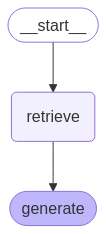

In [104]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [105]:
print(type(graph))

<class 'langgraph.graph.state.CompiledStateGraph'>


In [106]:
print(dir(graph))

['InputType', 'OutputType', '__abstractmethods__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__or__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__ror__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abatch_with_config', '_abc_impl', '_acall_with_config', '_aprepare_state_snapshot', '_atransform_stream_with_config', '_batch_with_config', '_call_with_config', '_defaults', '_is_protocol', '_prepare_state_snapshot', '_repr_mimebundle_', '_transform_stream_with_config', 'abatch', 'abatch_as_completed', 'aget_graph', 'aget_state', 'aget_state_history', 'aget_subgraphs', 'ainvoke', 'as_tool', 'assign', 'astream', 'astream_events', 'astream_log', 'atransform', 'attach_branch'

In [107]:
# Stream the pipeline steps

for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='f590c309-e213-4571-9ed9-5f20e81a1b7e', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 41}, page_content='Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.Agent System Overview#In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:Component One: Planning#A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.Task Decomposition#Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” 

/opt/anaconda3/lib/python3.11/site-packages/transformers/pipelines/question_answering.py:391: FutureWarning: Passing a list of SQuAD examples to the pipeline is deprecated and will be removed in v5. Inputs should be passed using the `question` and `context` keyword arguments instead.
  warnings.warn(


ValueError: Human: You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: What is Task Decomposition? 
Context: Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.Agent System Overview#In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:Component One: Planning#A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.Task Decomposition#Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an

to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to

step is removed.Reflexion (Shinn & Labash 2023) is a framework to equip agents with dynamic memory and self-reflection capabilities to improve reasoning skills. Reflexion has a standard RL setup, in which the reward model provides a simple binary reward and the action space follows the setup in ReAct where the task-specific action space is augmented with language to enable complex reasoning steps. After each action $a_t$, the agent computes a heuristic $h_t$ and optionally may decide to reset the environment to start a new trial depending on the self-reflection results.The heuristic function determines when the trajectory is inefficient or contains hallucination and should be stopped. Inefficient planning refers to trajectories that take too long without success. Hallucination is defined as encountering a sequence of consecutive identical actions that lead to the same observation in the environment.Self-reflection is created by showing two-shot examples to LLM and each example is a

Plugins and OpenAI API  function calling are good examples of LLMs augmented with tool use capability working in practice. The collection of tool APIs can be provided by other developers (as in Plugins) or self-defined (as in function calls).HuggingGPT (Shen et al. 2023) is a framework to use ChatGPT as the task planner to select models available in HuggingFace platform according to the model descriptions and summarize the response based on the execution results.The system comprises of 4 stages:(1) Task planning: LLM works as the brain and parses the user requests into multiple tasks. There are four attributes associated with each task: task type, ID, dependencies, and arguments. They use few-shot examples to guide LLM to do task parsing and planning.Instruction:(2) Model selection: LLM distributes the tasks to expert models, where the request is framed as a multiple-choice question. LLM is presented with a list of models to choose from. Due to the limited context length, task type 
Answer: argument needs to be of type (SquadExample, dict)

In [108]:
# Stream the model responses

for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")


/opt/anaconda3/lib/python3.11/site-packages/transformers/pipelines/question_answering.py:391: FutureWarning: Passing a list of SQuAD examples to the pipeline is deprecated and will be removed in v5. Inputs should be passed using the `question` and `context` keyword arguments instead.
  warnings.warn(


ValueError: Human: You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: What is Task Decomposition? 
Context: Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.Agent System Overview#In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:Component One: Planning#A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.Task Decomposition#Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an

to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to

step is removed.Reflexion (Shinn & Labash 2023) is a framework to equip agents with dynamic memory and self-reflection capabilities to improve reasoning skills. Reflexion has a standard RL setup, in which the reward model provides a simple binary reward and the action space follows the setup in ReAct where the task-specific action space is augmented with language to enable complex reasoning steps. After each action $a_t$, the agent computes a heuristic $h_t$ and optionally may decide to reset the environment to start a new trial depending on the self-reflection results.The heuristic function determines when the trajectory is inefficient or contains hallucination and should be stopped. Inefficient planning refers to trajectories that take too long without success. Hallucination is defined as encountering a sequence of consecutive identical actions that lead to the same observation in the environment.Self-reflection is created by showing two-shot examples to LLM and each example is a

Plugins and OpenAI API  function calling are good examples of LLMs augmented with tool use capability working in practice. The collection of tool APIs can be provided by other developers (as in Plugins) or self-defined (as in function calls).HuggingGPT (Shen et al. 2023) is a framework to use ChatGPT as the task planner to select models available in HuggingFace platform according to the model descriptions and summarize the response based on the execution results.The system comprises of 4 stages:(1) Task planning: LLM works as the brain and parses the user requests into multiple tasks. There are four attributes associated with each task: task type, ID, dependencies, and arguments. They use few-shot examples to guide LLM to do task parsing and planning.Instruction:(2) Model selection: LLM distributes the tasks to expert models, where the request is framed as a multiple-choice question. LLM is presented with a list of models to choose from. Due to the limited context length, task type 
Answer: argument needs to be of type (SquadExample, dict)

In [ ]:
# Evaluation and Experimentation 